In [2]:
from __future__ import division

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
import colorcet as cc
sns.set(style="white", palette="deep", color_codes=True)
sns.set_context("notebook", font_scale=1.2)
plt.rcParams["axes.labelsize"] = 16

def force_aspect(ax, aspect=1):
    """force a matplotlib axis to have the specified aspect ratio on the screen"""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    a = (np.max(xlim) - np.min(xlim)) / (np.max(ylim) - np.min(ylim))
    ax.set_aspect(a / aspect)
    
golden_ratio = 1.61803398875

# Introduction: Why authorship identification?

I started this project primarily to learn python, statistics, and in particular Bayesian inference.  It occurred to me that word patterns might be an interesting application for data mining: there's a lot of potential information hidden in word counts since there are so many of them!  Word choice is also very personal, and we intuitively know that different writers can each have a recognizable, individual style.  So word usage and authorship identification present an interesting opportunity to find and make sense of hidden patterns in a large quantity of data.

Authorship identification is already a small industry, and there exist a number of estabished methods.  In this experiment, I'll take a slightly different tack than what I've seen in the literature, however: I will focus not only on determining the most likely author of a given block of text, but also on producing an *honest, quantitative assessment* of the probability that my determination is correct.  I will sacrifice some sensitivty in favor of this latter goal.  Quantifying uncertainty is much more difficult than simply identifying the most probable outcome, and it's not always attempted.  After a few false starts, I will show that the odds I quote are correct, something which even the published papers I've read have not attempted.

I think this is an important issue, because statistical models often vastly overstate the certainty of their predictions.  A recent example is the 2016 presedential election, for which most models confidently forecast a clear win for Hillary Clinton.  Implicitly or not, these models hinged on an assumption that the past performance of polls would predict their future performance; such models therefore underestimate the chances of surprise in unusual elections.  A more important example is the 2007 financial crisis: among other problems, investment banks had chosen their bets based on an assumption about the likely numbers of mortgage defaults.  This calculation turned out to be incorrect, with disastrous consequences.  Other examples include overly-optimistic calculations about the likelihoods of nuclear accidents (on a large scale), or data loss in RAID arrays (on a much smaller scale).

Many of these faileres stem from assumptions that the processes being modeled are statistically independent (which is untrue in the case of mortgage defaults) and that the distributions of parameters is approximately normal (which is untrue in many if not most real-world cases).  In this project, I'll try to improve upon both assumptions.  To develop and test my methodology, I'll use the historical whodunnit problem of the disputed Federalist papers.  My analysis is inspired by a classic analysis by Frederick Mosteller and David Wallace in 1964.  To my knowledge, this was the first non-classified application of Bayesian statistics to a real-world problem.  Their paper was not only an imperssive achievement and a landmark in the history of Bayesian statistics, but they have a wry sense of humor and their writing is a joy to read... I highly recomment it!

## The case of the Federalist Papers

The *Federalist Papers* were published anonymously under the name *Publius* in 1787-1788 by Alexander Hamilton, John Jay, and James Madison to convince the state of New York to ratify the American Constitution.  Though they were essentially seen as propaganda at the time, the Federalist Papers do outline the logic and reasoning behind nearly every element of the constitution.  Since the american constitution is so maddeningly vague, on so many crucial points, the Federalist Papers still serve as an important metric of what the founding fathers may have intended.

The Federalist Papers consist of 77 essays, each 900 to 3,500 words in length.  Nearly everyone agrees that John Jay wrote five of the papers, leaving little doubt about his contribution.  Hamilton is identified as the author of 43 of the papers, and Madison of 14.  Three of the papers, numbers 18, 19, and 20, are understood to be jointly written by Hamilton and Madison, though the extent of each man's contribution is unknown.  Finally, the authorship of the remaining 12 papers (Numbered 49-58, 62, and 63) is in dispute between Hamilton and Madison.

We have this mystery because, even after the constitution was ratified, neither Madison nor Hamilton rushed to take credit for their papers.  This is likely because both later adopted interpretations of the constitution which were different from what they published in the Federalist Papers.  At the incistence of the authors, the papers therefore remained anonymous until Hamilton's death in a duel with Aaron Burr.  I'll quote Mosteller & Wallace's summary of the story:

> It was Hamilton's duel with Burr that precipitated the open designation of the Federalist authors. Premonitions of death spurred the New Yorker hurriedly to set all of his affairs in order. Among the matters that Hamilton, so typically a man of the eighteenth century, could not ignore was the judgment that posterity would make of his political career as spokesman for union and interpreter of the United States Constitution. His signature on certain controversial essays, while inconvenient during his life, might well add to his fame if issued posthumously. And so Hamilton stopped by the law office of Egbert Benson two days before his fatal meeting with Burr, and ostentatiously concealed in his friend's bookcase a slip of paper in his own handwriting listing by number the authors of the various essays in The Federalist. After his tragic death the memorandum was discovered as he had planned; nor were well-wishers loath to undertake the commemorative task of making certain his greatness was recognized. ... The Federalist suffered a sea-change: it was [issued in the] collected "Works of Hamilton." The Federalist, this publication implied, had not only been the original conception of a single man; it was for all practical purposes the creation of one individual.  ... If the Benson list was accurate, James Madison and John Jay could hardly be dignified with the title of co-authors of The Federalist; at most they were incidental helpers who had contributed a small wing to the massive intellectual structure designed and built by Alexander Hamilton.

At the time of this publication, James Madison was busy: he was president of the United States, the first president to live in the newly-constructed White House.  He was also fighting the war of 1812, during which marauding Canadians made it all the way to Washington, D. C. and burned the brand-new White House to the ground.  Years later, Madison took up this issue and claimed authorship of many more of the papers.  Again, quoting Mosteller & Wallace:

> James Madison's correction of Hamilton's claims in the Benson list was as non-provocative as positive contradiction could be. The Virginian said nothing of motives; he did not attribute the New Yorker's mistakes either to malice, enmity, or ambition. The misstatements in the Benson list, he suggested, were due only to the "fallibility of memory;" although the proportion of errors appeared exceedingly large, this was "owing doubtless to the hurry in which the memorandum was made out." Madison, however, after careful consideration and in the face of the dead man's claims was prepared to take oath that he himself had written twenty-nine of the essays instead of the fourteen attributed to him by Hamilton. He had ... also written Numbers 18, 19, and 20 (claimed by Hamilton as a joint product), merely incorporating in these three essays a small amount of supplementary material that Hamilton had gathered on the same subject. Madison thus laid claim to authorship of nearly forty per cent of The Federalist -- a far more respectable proportion than the twenty-odd per cent attributed to him by Hamilton.

So here is our problem.  Historical evidece has been considered, with widely varying conclusions.  The project was clearly Hamilton's idea (even though he was only 30 years old at the time!); Madison was at the Constutional Convention, however, and was therefore needed to explain the reasoning in some parts. Madison and Hamilton had since become political enemies, and each championed mutually exclusive interpretations of the Constitution they had cooperated in getting ratified.  The authorship of the disputed Federalist papers became something of a pawn in the country's political disputes, and historical analyses proved themselves to be strongly influenced by politics.  Again, quoting Mosteller & Wallace's summary:

> At this point a curious aspect of the Federalist controversy may be noted, quite distinct from the scholarly worth of the competing lists offered by the two principals. This is the clear-cut rhythm of acceptance and rejection by historical writers of the respective claims of the Virginian and the New Yorker, in successive periods of American history. For a period of forty years Madison was generally conceded to have discredited the Benson list; then during the succeeding half century this list was again restored to favor. This alternating sequence of belief and disbelief that marks the controversy is directly correlated with the see-saw of prestige between these two interpreters of the Con- stitution, depending upon whether agrarian or capitalistic interests were politically dominant in the country.

And so we will take a different tack, by analyzing the statistics of word usage patterns in the Federalist essays to try and discern their true authorship.  My approch is heavily inspired by Mosteller & Wallace's 1964 study, and I will reproduce their results in notebook #3.  I will solve the problem differently however, and my calculation leads to the best determination of the disputed papers that I'm aware of.  After a false start in notebook #4, this determination comes in notebook #5.

There's only one problem: Hamilton and Madison are *extremely* difficult to tell apart!  Both had mastered the *Addisonian* style of writing, which was florid, complicated, and oratorical.  I can illustrate this by computing bulk statistics such as sentence length for each of their works: 

In [3]:
import nltk
from collections import Counter

In [4]:
def sentence_lengths(filename):
    """returns a  list of all sentence lengths in filename"""
    
    with open(filename, 'r') as f:
        raw = f.read()

    lens = [ len(nltk.word_tokenize(sent)) 
             for sent in nltk.sent_tokenize(raw.lower()) ]

    return lens
    
mad_lens = sentence_lengths('../authors/madison-corpus-small.txt')
ham_lens = sentence_lengths('../authors/hamilton-corpus-small.txt')

In [5]:
print "M:", np.round(np.mean(mad_lens), 1), "p/m", np.round(np.std(mad_lens), 1)
print "H:", np.round(np.mean(ham_lens), 1), "p/m", np.round(np.std(ham_lens), 1)

M: 37.7 p/m 24.0
H: 37.7 p/m 22.0


Their average sentence lengths are *identical*, to better than one part in a thousand.  Maybe we can see some distinguishing feature in the *distribution* of their sentence lengths?

In [6]:
import pandas as pd

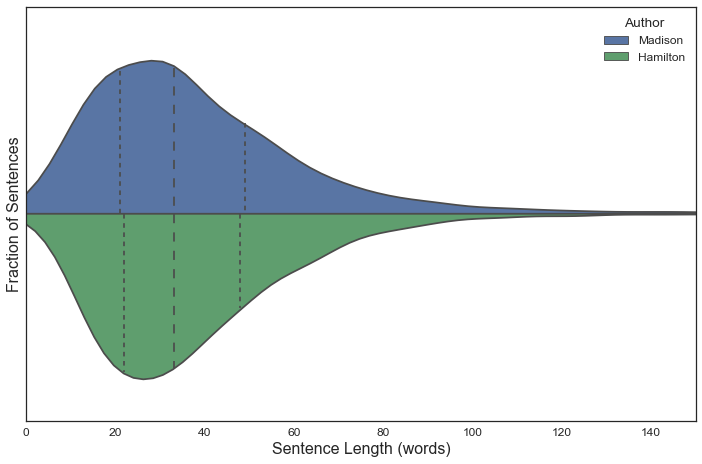

In [7]:
# it's overkill to use a dataframe here, but it's the easiest way to make a violin plot...
df = pd.DataFrame({'Author' : ["Madison"]*len(mad_lens) + ["Hamilton"] * len(ham_lens),
                   'Sentence Length' : mad_lens + ham_lens,
                   'PDF'  : ["PDF"] * (len(mad_lens) + len(ham_lens))})

fig, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(y = 'PDF', x = 'Sentence Length', hue = 'Author',
               data=df, split=True,
               scale="area", inner="quartile",
               ax=ax, bw=0.25)

ax.set_yticks([]);
ax.set_xlim([0.0, 150.0]);
ax.set_xlabel('Sentence Length (words)');
ax.set_ylabel('Fraction of Sentences');

force_aspect(ax, golden_ratio)

While it seems that Madison may have a *slightly* larger standard deviation, that may also be because his corpus is *much* smaller, by almost a factor of 3!

You can see this is going to be hard!  By some measures, Madison and Hamilton are essentially identical, and we won't be able to disambiguate them by gross statistics such as sentence length or the size of their lexicon.

(also: they write *extremely* long sentences! In case you don't believe me:)

In [15]:
with open('../authors/madison-corpus-small.txt', 'r') as f:
        raw = f.read()
        
long_sentences = [ sent
                  for sent in nltk.sent_tokenize(raw) 
                  if len(nltk.word_tokenize(sent)) > 150 ]

import random
sent = random.choice(long_sentences)
print len(nltk.word_tokenize(sent)), 'words:'
print sent

153 words:
And as
it is to be appropriated to this use with the consent of the State
ceding it; as the State will no doubt provide in the compact for the
rights and the consent of the citizens inhabiting it; as the
inhabitants will find sufficient inducements of interest to become
willing parties to the cession; as they will have had their voice in
the election of the government which is to exercise authority over
them; as a municipal legislature for local purposes, derived from
their own suffrages, will of course be allowed them; and as the
authority of the legislature of the State, and of the inhabitants of
the ceded part of it, to concur in the cession, will be derived from
the whole people of the State in their adoption of the Constitution,
every imaginable objection seems to be obviated.


# Methodology

My approach will be to analyze patterns in the authors' usage of *stop words*, or *function words*.  These are words which should be relatively independent of the topic being discussed, and I hope their patterns of usage will reflect each author's individual style.

There's a fairly significant body of research into what defines a stop word, and how to determine the extent to which word usage depends on context; unfortunately, I have not had the time to dive into this literature.  For now, I'll use the following list of stop words, which is as much a personal guess as anything else.  My analysis is not sensitive to words in this list which turn out to be irrelevant; however, it is sensitive to words which depend more strongly on context than on the author writing them.

In [16]:
stopwords = ["a", "about", "above", "according", "across", "affect", "after", \
"again", "against", "all", "almost", "alone", "along", "already", \
"also", "although", "always", "among", "an", "and", "another", "any", \
"anyone", "anything", "anywhere", "apt", "are", "argue", "around", \
"as", "asserted", "at", "back", "be", "became", "because", "become", \
"becomes", "been", "before", "behind", "being", "better", "between", \
"both", "but", "by", "can", "cannot", "common", "commonly", \
"comparable", "consequently", "considerable", "could", "course", \
"degree", "did", "do", "done", "down", "dramatically", "during", \
"each", "either", "enough", "even", "ever", "every", "everyone", \
"everything", "everywhere", "extent", "few", "find", "first", \
"follow", "for", "four", "from", "full", "further", "get", "give", \
"go", "had", "has", "have", "he", "hence", "her", "here", "herself", \
"him", "himself", "his", "how", "however", "if", "imply", \
"importance", "in", "interest", "into", "is", "it", "its", "itself", \
"join", "keep", "kind", "largely", "last", "least", "less", "made", \
"many", "may", "me", "might", "more", "moreover", "most", "mostly", \
"much", "must", "my", "myself", "necessary", "never", "next", "no", \
"nobody", "noone", "nor", "not", "nothing", "now", "nowhere", "of", \
"off", "often", "on", "once", "one", "only", "or", "other", "others", \
"our", "out", "over", "part", "particularly", "per", "perhaps", \
"possible", "principle", "put", "rather", "requisite", "same", \
"second", "see", "seem", "seemed", "seeming", "seems", "several", \
"shall", "she", "should", "show", "side", "since", "so", "some", \
"someone", "something", "somewhere", "still", "substance", "such", \
"suggest", "take", "than", "that", "the", "their", "them", "then", \
"there", "therefore", "these", "they", "thing", "this", "those", \
"though", "three", "through", "throughout", "thus", "to", "together", \
"too", "toward", "two", "typical", "typically", "under", \
"unexpected", "until", "up", "upon", "us", "use", "using", "very", \
"was", "we", "well", "were", "what", "when", "where", "whether", \
"which", "while", "whilst", "who", "whole", "whose", "why", "will", \
"with", "within", "without", "would", "yet", "you", "your", "yours"]

With hindsight, I should have used a smaller list of stopwords... my calculation ended up being computationally expensive, and shortening this list would be an obvious way to cut costs without sacrificing accuracy.

Next comes the task of tallying up word usage.  Mosteller & Wallace describe their method:

> Certain *Federalist* papers were typed on roll paper (adding machine paper, one word per line) and proofed.  The words on the rool paper were then cut and sorted into alphabetical order.  (During this operation a deep breath created a storm of confetti and a permanent enemy.)  The count of each word was tabulated by hand and typed or written on a master sheet.  A complete count for the total number of words in the particular paper was also tabulated and recorded.  This total count was later checked and rechecked (but only a few words were recounted).
  
also:

> Williams and Mosteller independently counted the number of words in all the sentences of *The Federalist*, and their first frustration was the discovery of an important empirical principle -- people cannot count, at least not very high (Miller, 1956; Wundt, 1912)

If you ever want to feel spoiled for having access to a computer, you should read old science papers and consider what people were able to achieve using typewriters and slide rules!  This includes the Apollo missions, the development of nuclear energy and weapons, and of course, the invention of computers.

I'll take the easy road and use the natural language toolkit, along with Python's Counter class to count word occurrences in each document:

In [17]:
def measure(filename):
    """tally occurrences of each word in stopwords, for the text in filename"""
    with open(filename, 'r') as f:
        raw = f.read()

    all_words = nltk.word_tokenize(raw.lower())
    num = len(all_words)

    c = Counter(all_words)
    x = [ c[w] for w in stopwords ]
    
    return np.asarray(x) / num

And I'll use this to look at a sample of documents I have handy (these are not in the github repo, due to copyright issues, but you can easily supply your own text files if you like):

In [18]:
import glob

In [19]:
files = glob.glob('../authors/*/*.txt') + glob.glob('../authors/*/*/*.txt')
files.sort()
data = np.asarray(map(measure, files))

In [20]:
# sort words by mean usage and transpose
idx = np.flipud(np.sum(data, axis=0).argsort()) # descending
data = data[:,idx]
data = np.transpose(data)

# floor word usage at one occurrence per hundred thousand and take the logarithm
data = np.log(data + 1.0e-5)

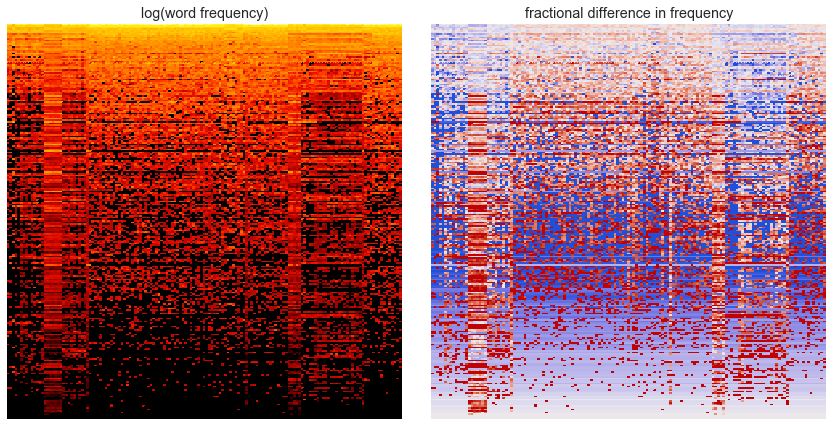

In [21]:
fig=plt.figure(figsize=(12, 6))
gs=GridSpec(1,2) # one row, two columns

ax1=fig.add_subplot(gs[0,0]) # first row, first column
ax2=fig.add_subplot(gs[0,1]) # first row, second column

# first, show log of the raw word usage:
#
sns.heatmap(data, cmap=cc.fire, cbar=False, ax=ax1)
ax1.set_xticks([]);
ax1.set_yticks([]);
ax1.set_title('log(word frequency)')

# next, show a fractional difference from the mean to highlight differences in patterns
# colorbar saturates at Delta(log(usage)) = 2, or about a factor of 7 difference in counts
#
d1 = np.transpose(data)
s = np.mean(d1, axis=0)
d1 = np.transpose(d1-s)
sns.heatmap(d1, cmap=cc.coolwarm, vmin=-2, vmax=+2, cbar=False, ax=ax2)
ax2.set_xticks([]);
ax2.set_yticks([]);
ax2.set_title('fractional difference in frequency')

# i like square plots!
force_aspect(ax1, 1)
force_aspect(ax2, 1)

gs.tight_layout(fig)

In this plot, the stop words from from top to bottom, sorted by their average rate of usage.  The documents run from left to right, sorted by author.  To the extend that each author has a unique and individual style, it should be visible as a horizontal stripe in this plot.

Eyeballing this plot, there does appear to be some structure in word usage, but there's also a substantial amount of noise.  The noise in this case dominates the signal, and I'm willing to bet that you can't easily guess how many distinct authors are represented in this sample, or where the divisions between all of them are.

How about if I bin the data and just show the averages for each author... maybe then we can spot the differences between them?  Let's try it!

In [13]:
authors = [('Ann Bronte',           '../authors/bronte-anne/'),
           ('Charlotte Bronte',     '../authors/bronte-charlotte/'),
           ('Emily Bronte',         '../authors/bronte-emily/'),
           ('James',                '../authors/guillochon/'),
           ('Mike',                 '../authors/mike/'),
           ('Hamilton (Essays)',    '../authors/hamilton/'),
           ('Madison (Essays)',     '../authors/madison/'),
           ('Disputed Federalist',  '../authors/unknown-federalist/'),
           ('Madison (Speeches)',   '../authors/madison-speeches/'),
           ('Hamilton (Speeches)',  '../authors/hamilton-speeches/'),
           ('John Jay',             '../authors/jay/'),
           ('Mary Shelley',         '../authors/mary-shelley/'),
           ('Percy Shelley',        '../authors/percy-shelley/')]

In [14]:
def measure_author(author):
    """tally stopwords for each file in the author's directory,
    then return the average usage"""

    name, directory = author

    data = map(measure,
               glob.glob('{0}/*.txt'.format(directory)) 
               + glob.glob('{0}/*/*.txt'.format(directory)))

    data = np.asarray(data)

    return np.mean(data, axis=0)

In [15]:
data = np.asarray(map(measure_author, authors))

# sort words by mean usage
idx = np.flipud(np.sum(data, axis=0).argsort()) # descending order
data = data[:,idx]
data = np.transpose(data)

# again, floor it at one occurrence per hundred thousand and take the log:
data = np.log(data + 1.0e-5)

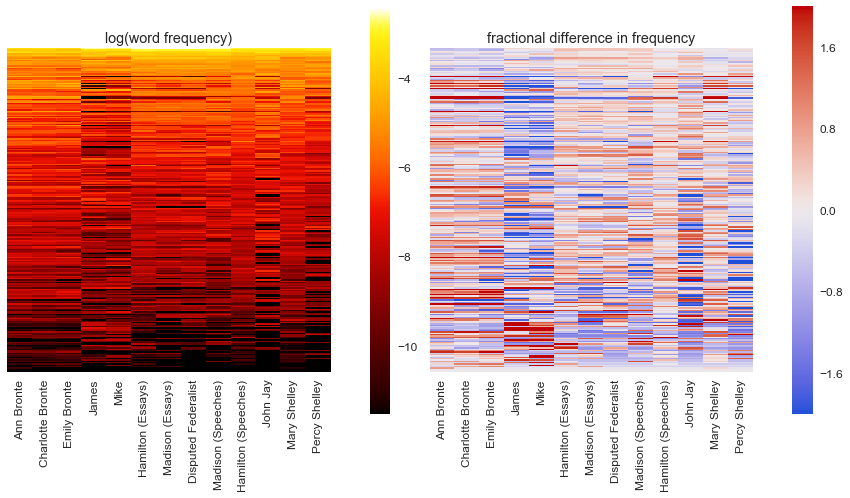

In [16]:
fig=plt.figure(figsize=(12, 7))
gs=GridSpec(1,12) # six rows, 12 columns

# plots
ax1=fig.add_subplot(gs[:,0:5])  # all rows, columns 1-5
ax2=fig.add_subplot(gs[:,6:11]) # first row, columns 7-11

# colorbars
cax1 = fig.add_subplot(gs[:,5])  # column 6
cax2 = fig.add_subplot(gs[:,11]) # column 12

# again, start by showing the raw word usage frequency:
#
sns.heatmap(data, cmap=cc.fire, cbar_ax = cax1, cbar=True, ax=ax1)
ax1.set_title('log(word frequency)')

# followed by fractional difference from the mean:
# colorbar saturates at Delta(log(usage)) = 2, or about a factor of 7 difference in counts
#
d1 = np.transpose(data)
s = np.mean(d1, axis=0)
d1 = np.transpose((d1-s))
sns.heatmap(d1, cmap=cc.coolwarm, vmin=-2, vmax=+2, cbar_ax = cax2, cbar=True, ax=ax2)
ax2.set_title('fractional difference in frequency')

author_names = [name for name, _ in authors]
ax1.set_xticklabels(author_names, rotation=90);
ax2.set_xticklabels(author_names, rotation=90);
ax1.set_yticks([]);
ax2.set_yticks([]);

# make plots square!
force_aspect(ax1, 1)
force_aspect(ax2, 1)

cax1.set_aspect(aspect=20, adjustable='box-forced', anchor='C')
cax2.set_aspect(aspect=20, adjustable='box-forced', anchor='C')

gs.tight_layout(fig)

Now, you can see some distinct patterns in word usage among the different authors... so there may be some hope!  But you can also see there's a substantial amount of noise, and the possibility of confusion seems dire: note the fairly substantial differences between Hamilton's essays and his speeches, and likewise for Madison -- in fact, their essays are more similar to each others's than they are to their own speeches!

This figure also suggests that the Bronte sisters will be diffult to tell apart... really, the only people who stand out strongly here are the astrophysicists (James and me), Percy Shelly, whose corpus consists of poetry, and John Jay, who's apparently just weird.  (no wonder there was never any doubt about his authorship!)

In the following three notebooks, I'll explore some different ways of using this information to disambiguate authorship.  The final goal will be to reveal the true authors of the disputed Federalist papers!